1. Replace empty strings with NaN - DONE
2. Remove the footnotes from the 'Other Source Deaths' column - DONE but revisit row 1238?
3. Convert Magnitude to a numeric - DONE
4. Create a new column ('deaths') that evaluates the four total-death columns ('PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', and 'Other Source Deaths') and populates the new column with the highest value.
5. Explore the data in terms of when and where earthquakes occurred and how severe they were (magnitude, deaths, secondary effects).

- Are there factors that make an earthquake more likely? 
- Are there factors that make an earthquake more deadly? 
- Where would you live if you wanted to eliminate the risk of experiencing an earthquake? 
- Where would you avoid living?

In [213]:
import numpy as np
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup as BS
import matplotlib.pyplot as plt
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import Point
import seaborn as sns
#hv.notebook_extension('bokeh')
import matplotlib as mpl
mpl.rcParams.update({'font.size': 18})
sns.set(context='notebook',rc={'figure.figsize':(15,8)})

pd.set_option('display.max_rows', 10000)

In [214]:
# create a Request object for the wikipedia page for the list of deadly earthquakes since 1900
response = requests.get('https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900')

# read the resulting HTML into a variable called result_text
result_text = response.text

In [215]:
result_text;

In [216]:
# create the soup by constructing a BS object from the html page and the appropriate parser
soup = BS(result_text, 'html.parser')

In [217]:
soup.title

<title>List of deadly earthquakes since 1900 - Wikipedia</title>

In [218]:
#print(soup.prettify())

In [219]:
table = soup.find_all('table',{'class':'sortable wikitable'})

In [225]:
df = pd.read_html(str(table))

In [226]:
df = df[0]

In [227]:
df.rename(columns=df.iloc[0],inplace=True)
df.rename(columns={'Origin (UTC)':'TimeUTC', 'Present-day country and link to Wikipedia article':'Country'}, inplace=True)

In [228]:
df.drop([0],inplace=True)

In [230]:
df['Other Source Deaths'] = df['Other Source Deaths'].str.extract('(\d+)', expand=False)
df.drop(df.loc[df['Lat']=='?'].index, inplace=True)
#df = df[df.Lat != '?']
df

TimeUTC                                            Country  \
1     1900-05-11 17:23                                              Japan   
2     1900-07-12 06:25                                             Turkey   
3     1900-10-29 09:11                                          Venezuela   
4     1901-02-15 00:00                                              China   
5     1901-03-31 07:11                                           Bulgaria   
6     1901-08-09 09:23                                              Japan   
7     1901-11-15 20:15          New Zealand (see 1901 Cheviot earthquake)   
8     1902-01-30 14:01                                              Japan   
9     1902-02-13 09:39                                         Azerbaijan   
10    1902-03-09 07:46                                             Turkey   
11    1902-04-19 02:23          Guatemala (see 1902 Guatemala earthquake)   
12    1902-07-03 15:36                                              China   
13    1902-08-22 03:00                                              China   
14          1902-09-19                                          Australia   
15    1902-12-16 05:07                                         Uzbekistan   
16    1903-03-29 22:30                                  Judea and Samaria   
17          1903-04-28             Turkey (see 1903 Manzikert earthquake)   
18    1903-05-28 03:58                                             Turkey   
19    1903-08-11 04:32                                             Greece   
20    1903-09-25 01:20                                               Iran   
21    1904-04-24 06:39                                             Taiwan   
22    1904-08-11 05:56                                             Greece   
23    1904-08-30 11:42                                              China   
24    1904-11-05 20:25                Taiwan (see 1904 Douliu earthquake)   
25    1905-04-04 00:50                                              India   
26    1905-06-01 04:42                                            Albania   
27    1905-06-02 05:39                                              Japan   
28    1905-09-08 01:43               Italy (see 1905 Calabria earthquake)   
29    1905-11-08 22:06                                             Greece   
30    1906-01-31 15:36     Ecuador (see 1906 Ecuador–Colombia earthquake)   
31    1906-03-16 22:42               Taiwan (see 1906 Meishan earthquake)   
32    1906-04-13 19:18                                             Taiwan   
33    1906-04-18 13:12  United States (see 1906 San Francisco earthquake)   
34    1906-08-17 00:40             Chile (see 1906 Valparaíso earthquake)   
35    1906-12-22 18:21                                              China   
36    1907-01-04 05:19                                          Indonesia   
37    1907-01-14 21:36             Jamaica (see 1907 Kingston earthquake)   
38    1907-04-15 06:08                                             Mexico   
39    1907-04-18 20:59                                        Philippines   
40    1907-10-21 04:23           Tajikistan (see 1907 Qaratog earthquake)   
41    1908-01-11 03:35                                             Taiwan   
42    1908-12-28 04:20                Italy (see 1908 Messina earthquake)   
43    1909-01-19 04:56                                             Turkey   
44          1909-01-23                Iran (see 1909 Borujerd earthquake)   
45    1909-02-09 11:24                                             Turkey   
46    1909-04-14 19:53                                             Taiwan   
47    1909-04-23 17:39                                           Portugal   
48    1909-05-11 15:54                                              China   
49    1909-06-03 18:40                                          Indonesia   
50          1909-06-11              France (see 1909 Provence earthquake)   
51    1909-08-14 06:31                                              Japan   
52    1909-

In [132]:
# replace empty strings with NaN
# I think this happened automatically when I read it into a dataframe
df.replace('', np.nan, inplace=True)
df.dropna(subset=['Lat', 'Long'], inplace=True)
#df.replace(r'^\s+$', np.nan, regex=True,inplace=True)

In [133]:
df['Magnitude'], df['Units'] = df['Magnitude'].str.split(' ', 1).str
df['Year'] = df.TimeUTC.astype(str).str[:4]
df['Year'] = pd.to_numeric(df['Year'])

In [134]:
df.Country = df.Country.str.split('(', 1).str[0]
df.Country = df.Country[:-2]

In [135]:
df['Long'] = pd.to_numeric(df['Long'], errors='coerce')
df['Lat'] = pd.to_numeric(df['Lat'], errors='coerce')
df['Magnitude'] = pd.to_numeric(df['Magnitude'], errors='coerce')
df['Depth (km)'] = pd.to_numeric(df['Depth (km)'], errors='coerce')
df['PDE Shaking Deaths'] = pd.to_numeric(df['PDE Shaking Deaths'], errors='coerce')
df['PDE Total Deaths'] = pd.to_numeric(df['PDE Total Deaths'], errors='coerce')
df['Utsu Total Deaths'] = pd.to_numeric(df['Utsu Total Deaths'], errors='coerce')
df['EM-DAT Total Deaths'] = pd.to_numeric(df['EM-DAT Total Deaths'], errors='coerce')
df['Other Source Deaths'] = pd.to_numeric(df['Other Source Deaths'], errors='coerce')

In [136]:
df['Deaths'] = df.filter(regex='Deaths').apply(np.nanmax, axis=1)
df['Deaths'] = pd.to_numeric(df['Deaths'], errors='coerce')

/Users/gcdunn/anaconda3/lib/python3.6/site-packages/pandas/core/apply.py:242: RuntimeWarning: All-NaN axis encountered
  labels=labels)


In [137]:
df

TimeUTC                               Country      Lat  \
1     1900-05-11 17:23                                 Japan  38.7000   
2     1900-07-12 06:25                                Turkey  40.3000   
3     1900-10-29 09:11                             Venezuela  11.0000   
4     1901-02-15 00:00                                 China  26.0000   
5     1901-03-31 07:11                              Bulgaria  43.4000   
6     1901-08-09 09:23                                 Japan  40.5000   
7     1901-11-15 20:15                          New Zealand  -43.0000   
8     1902-01-30 14:01                                 Japan  40.5000   
9     1902-02-13 09:39                            Azerbaijan  40.7000   
10    1902-03-09 07:46                                Turkey  40.7000   
11    1902-04-19 02:23                            Guatemala   14.0000   
12    1902-07-03 15:36                                 China  43.2000   
13    1902-08-22 03:00                                 China  40.0000   
14          1902-09-19                             Australia -35.0000   
15    1902-12-16 05:07                            Uzbekistan  40.8000   
16    1903-03-29 22:30                     Judea and Samaria  32.2000   
17          1903-04-28                               Turkey   39.1400   
18    1903-05-28 03:58                                Turkey  40.9000   
19    1903-08-11 04:32                                Greece  36.3600   
20    1903-09-25 01:20                                  Iran  35.2000   
21    1904-04-24 06:39                                Taiwan  23.5000   
22    1904-08-11 05:56                                Greece  37.7500   
23    1904-08-30 11:42                                 China  30.0000   
24    1904-11-05 20:25                               Taiwan   23.5000   
25    1905-04-04 00:50                                 India  33.0000   
26    1905-06-01 04:42                               Albania  42.1000   
27    1905-06-02 05:39                                 Japan  34.1000   
28    1905-09-08 01:43                                Italy   39.0000   
29    1905-11-08 22:06                                Greece  40.0000   
30    1906-01-31 15:36                              Ecuador    1.0000   
31    1906-03-16 22:42                               Taiwan   23.6000   
32    1906-04-13 19:18                                Taiwan  23.6000   
33    1906-04-18 13:12                        United States   38.0000   
34    1906-08-17 00:40                                Chile  -33.0000   
35    1906-12-22 18:21                                 China  43.5000   
36    1907-01-04 05:19                             Indonesia   2.0000   
37    1907-01-14 21:36                              Jamaica   18.2000   
38    1907-04-15 06:08                                Mexico  17.0000   
39    1907-04-18 20:59                           Philippines  14.0000   
40    1907-10-21 04:23                           Tajikistan   38.0000   
41    1908-01-11 03:35                                Taiwan  23.0000   
42    1908-12-28 04:20                                Italy   38.0000   
43    1909-01-19 04:56                                Turkey  38.6000   
44          1909-01-23                                 Iran   33.0000   
45    1909-02-09 11:24                                Turkey  40.0000   
46    1909-04-14 19:53                                Taiwan  25.0000   
47    1909-04-23 17:39                              Portugal  38.9000   
48    1909-05-11 15:54                                 China  24.4000   
49    1909-06-03 18:40                             Indonesia  -2.0000   
50          1909-06-11                               France   43.7000   
51    1909-08-14 06:31                                 Japan  35.4000   
52    1909-10-20 23:41                              Pakistan  30.0000   
53    1909-11-10 06:13                                 Japan  32.3000   
54    1910-01-08 14:49                                 China  35.0000   


In [138]:
#df = df[(df.Lat.astype('str') != '?') & (df.Long.astype('str') != '?')]
#df = df[(df.Lat.astype('str') != 'NaN') & (df.Long.astype('str') != 'NaN')]
#df = df[df['Country']!='Macedonia ']
#df

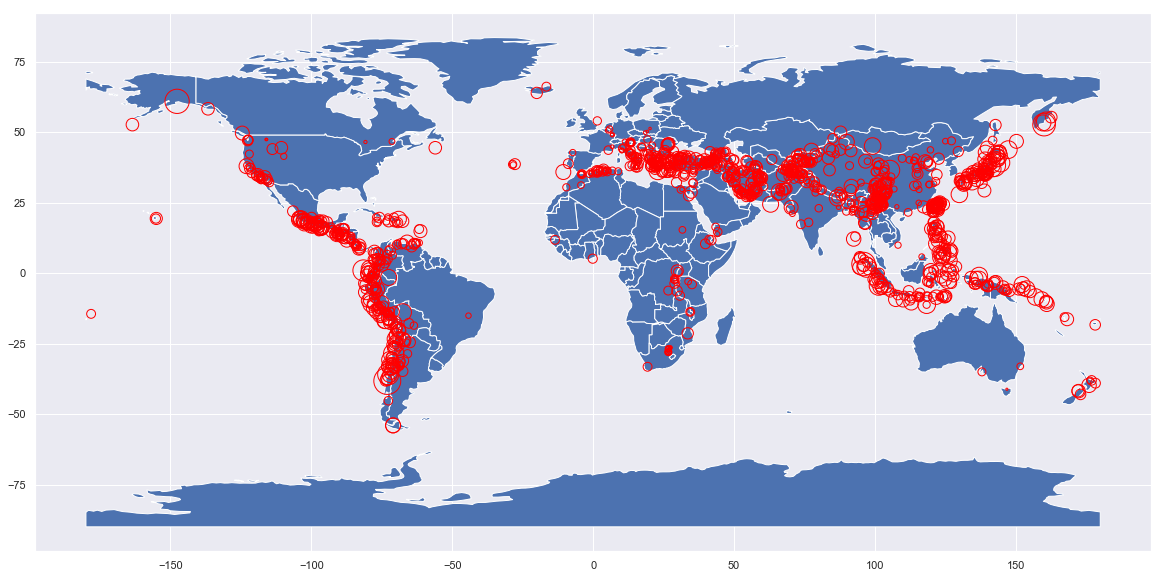

In [139]:
geometry = [Point(xy) for xy in zip(df.Long.astype('float64'), df.Lat.astype('float64'))]
tempdf = df.drop(['Long', 'Lat'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(tempdf, crs=crs, geometry=geometry)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(20,15));
gdf.plot(ax=ax,marker='o',facecolor='None',edgecolor='red',markersize=2.0**df.Magnitude.astype('float64'));

In [140]:
import folium
from folium import IFrame
from folium.plugins import MarkerCluster
width, height = 310,110
popups, locations = [], []

map1 = folium.Map([-15.783333, -47.866667], zoom_start=1, tiles='cartodbpositron')
count = 0
for row in df.iterrows():
    row_values = row[1] 
    locations.append([row_values['Lat'], row_values['Long']])
    #print(count,[row_values['Lat'], row_values['Long']])
    country = row_values['Country'] #.encode('ascii', 'xmlcharrefreplace')
    magnitude = row_values['Magnitude']
    popup = (str(row_values['Country']) + '<br/>' + 
        'Year: ' + str(row_values['Year']) + '<br/>' +
        'Magnitude: ' + str(row_values['Magnitude']) + '<br/>' +
        'Deaths: ' + str(row_values['Deaths'])).replace("'", "`")
    #marker = folium.Marker(location = location, popup = popup)
    #marker.add_to(map1)
    #iframe = IFrame(table('Earthquakes', country, magnitude), width=width, height=height)
    popups.append(popup)
    t = folium.FeatureGroup(name='Earthquakes')
    count += 1

t.add_child(MarkerCluster(locations=locations, popups=popups))
map1.add_child(t)
map1.add_child(folium.LayerControl())
map1

(1, 1122018.4543019608)

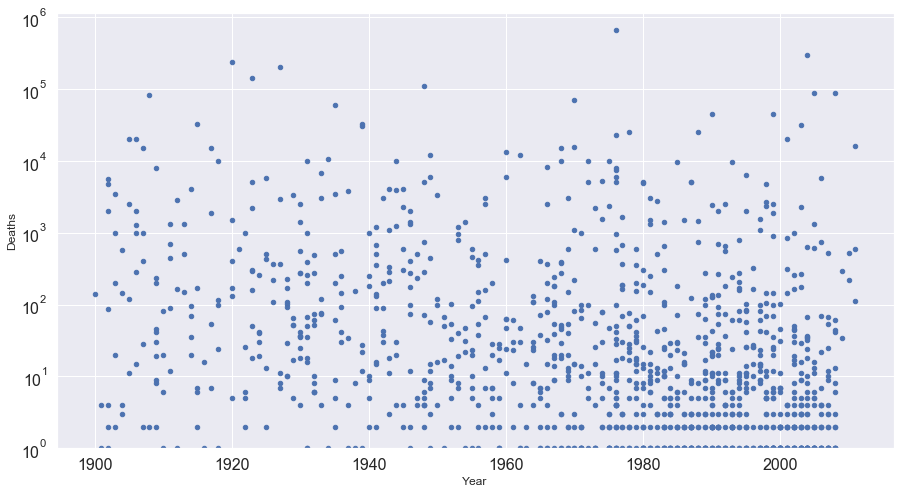

In [157]:
#plt.figure(figsize=(15,8))
#df.dropna(subset=['Deaths'])
df.plot(kind='scatter',x='Year',y='Deaths',figsize=(15,8),fontsize=16, marker='o')
plt.semilogy()
plt.ylim(bottom=1)
#plt.locator_params(axis='x', numticks=4)

#plt.xticks(rotation=70);

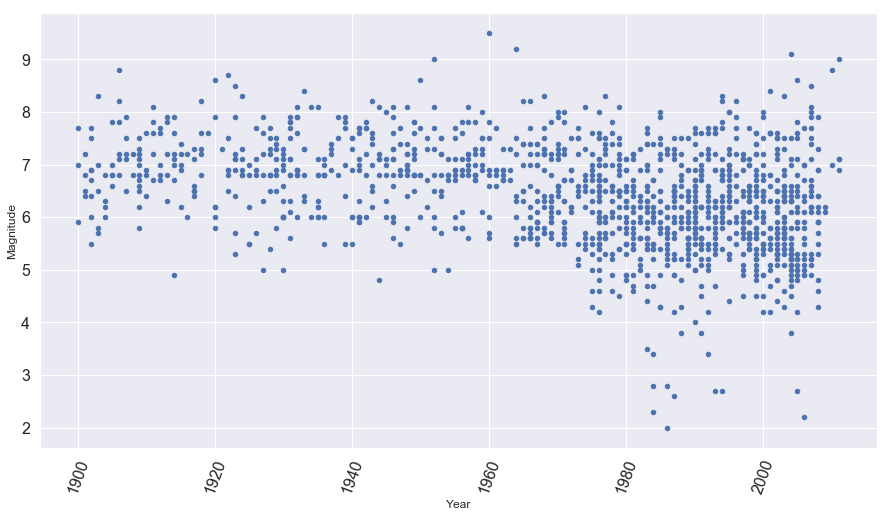

In [142]:
#plt.figure(figsize=(15,8))
df.plot(kind='scatter',x='Year',y='Magnitude',figsize=(15,8),fontsize=16);
#plt.locator_params(axis='x', numticks=4)
plt.xticks(rotation=70);

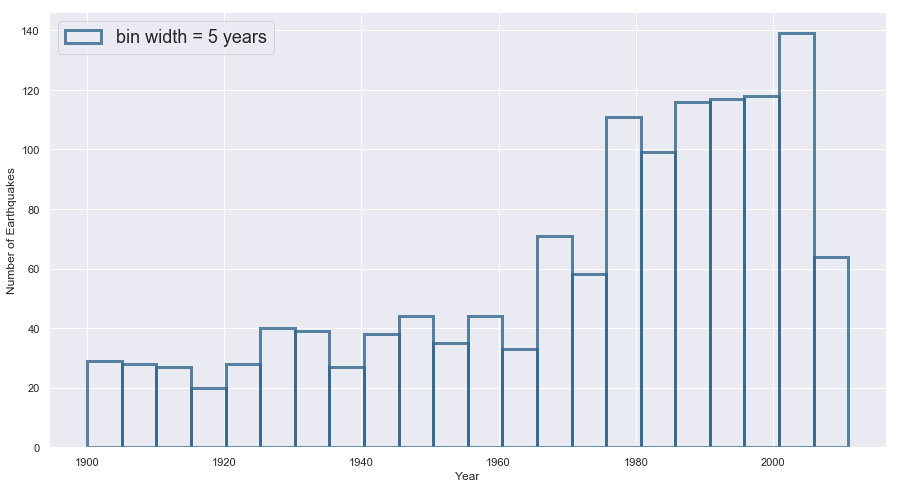

In [168]:
#plt.plot(figsize=(15,8))
sns.distplot(df.Year,kde=False,bins=int((max(df.Year)-min(df.Year))/5.), hist_kws={"histtype": "bar", \
    "linewidth": 3,"alpha": 0.8, "edgecolor": "#31668a", "facecolor": "None", "label":"bin width = 5 years"})
plt.ylabel('Number of Earthquakes')
plt.legend(fontsize=18)

(1, 1122018.4543019608)

<Figure size 1080x576 with 0 Axes>

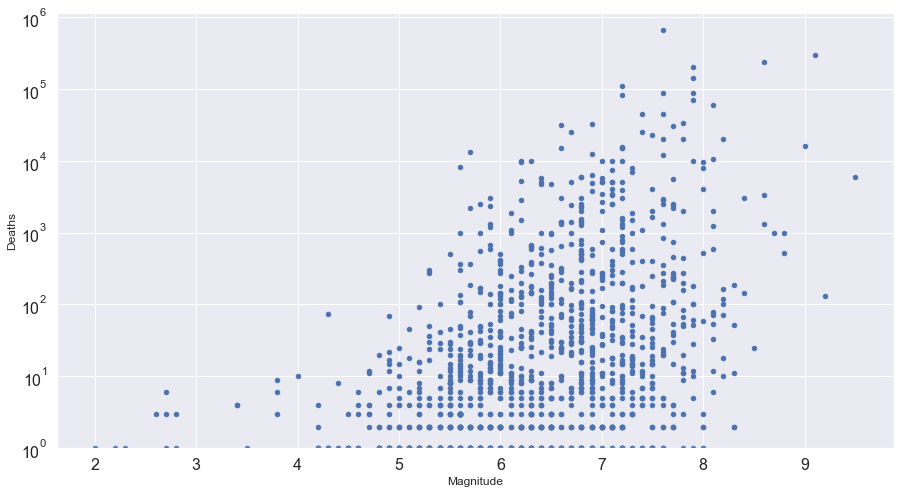

In [144]:
plt.figure(figsize=(15,8))
df.plot(kind='scatter',x='Magnitude',y='Deaths',figsize=(15,8),fontsize=16, marker='o')
plt.semilogy()
plt.ylim(bottom=1)
#plt.locator_params(axis='x', numticks=4)
#plt.xticks(rotation=70);

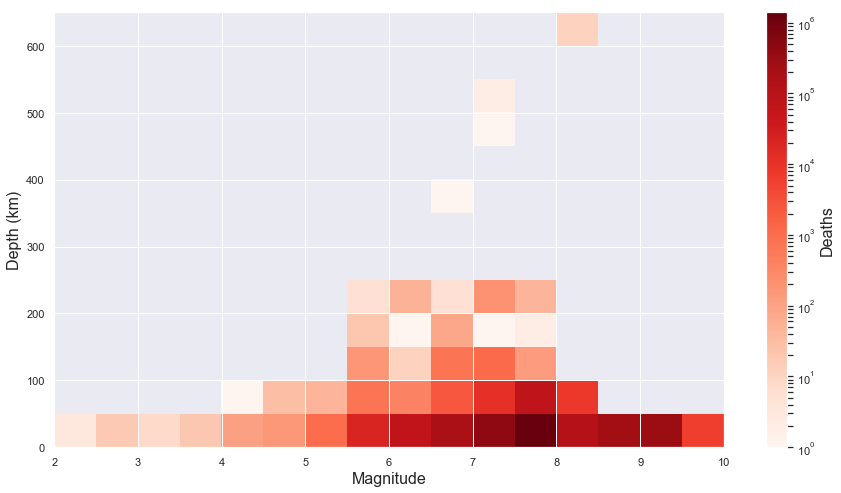

In [208]:
xedges = [2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]
yedges = [0,50,100,150,200,250,300,350,400,450,500,550,600,650]
from matplotlib.colors import LogNorm
plt.hist2d(df.Magnitude, df['Depth (km)'], weights=df.Deaths, bins=[xedges,yedges], cmap='Reds', norm=LogNorm())
plt.xlabel('Magnitude',fontsize=16)
plt.ylabel('Depth (km)',fontsize=16)
plt.colorbar().set_label(label='Deaths',size=16)
plt.show()

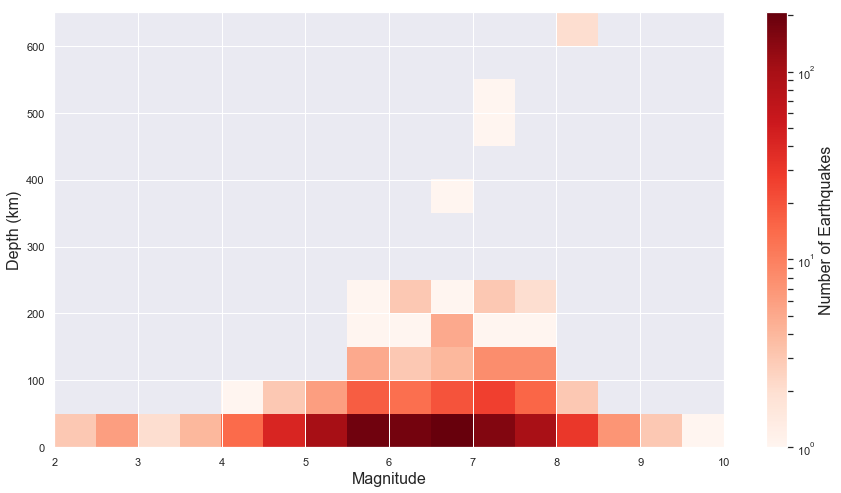

In [212]:
xedges = [2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]
yedges = [0,50,100,150,200,250,300,350,400,450,500,550,600,650]
from matplotlib.colors import LogNorm
plt.hist2d(df.Magnitude, df['Depth (km)'], bins=[xedges,yedges], cmap='Reds', norm=LogNorm())
plt.xlabel('Magnitude',fontsize=16)
plt.ylabel('Depth (km)',fontsize=16)
plt.colorbar().set_label(label='Number of Earthquakes',size=16)
plt.show()